# Balanced Dataset Classifier Comparison

**Objective**: Compare classification performance across multiple balanced datasets and classifier models.

**Datasets to Test**:
1. Original Enhanced (imbalanced, new features)
2. Balanced 1:1 (Random Undersampling)
3. Balanced 2:1 (Moderate Undersampling)
4. SMOTE (Synthetic Oversampling)
5. SMOTE+Tomek (Hybrid)

**Models to Compare**:
- XGBoost (baseline + weighted)
- Random Forest
- Extra Trees
- Logistic Regression
- Gradient Boosting
- LightGBM
- CatBoost

**Evaluation Strategy**:
1. Split each dataset: 80% training/validation, 20% hold-out test (temporal split)
2. Time-Series Cross-Validation on 80% training set (5 folds)
3. Final evaluation on untouched 20% hold-out test set
4. Focus on Class 1 (Bull regime) F1-score and Recall

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, precision_score, recall_score, accuracy_score,
    roc_auc_score, roc_curve
)
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Boosting libraries
import xgboost as xgb
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available")

try:
    import catboost as cb
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("CatBoost not available")

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Project paths
project_root = Path('..').resolve()
data_dir = project_root / 'data' / 'balanced_datasets'

print(f"Data directory: {data_dir}")
print(f"Available datasets: {list(data_dir.glob('*.csv'))}")

CatBoost not available
Data directory: E:\Coding\Crypto_Research\data\balanced_datasets
Available datasets: [WindowsPath('E:/Coding/Crypto_Research/data/balanced_datasets/feature_metadata.csv'), WindowsPath('E:/Coding/Crypto_Research/data/balanced_datasets/regime_classification_balanced_1to1.csv'), WindowsPath('E:/Coding/Crypto_Research/data/balanced_datasets/regime_classification_balanced_2to1.csv'), WindowsPath('E:/Coding/Crypto_Research/data/balanced_datasets/regime_classification_original_enhanced.csv'), WindowsPath('E:/Coding/Crypto_Research/data/balanced_datasets/regime_classification_smote.csv'), WindowsPath('E:/Coding/Crypto_Research/data/balanced_datasets/regime_classification_smote_tomek.csv')]


## 1. Load All Datasets and Split Train/Test

Hold out last 20% of each dataset for final testing

In [2]:
# Load all datasets and split train/test
datasets_train = {}
datasets_test = {}

dataset_files = {
    'Original': 'regime_classification_original_enhanced.csv',
    'Balanced_1to1': 'regime_classification_balanced_1to1.csv',
    'Balanced_2to1': 'regime_classification_balanced_2to1.csv',
    'SMOTE': 'regime_classification_smote.csv',
    'SMOTE_Tomek': 'regime_classification_smote_tomek.csv'
}

print("Loading datasets and creating train/test splits (80/20 temporal)...")
print("="*80)

for name, filename in dataset_files.items():
    filepath = data_dir / filename
    if filepath.exists():
        df = pd.read_csv(filepath, index_col=0)
        
        # Split 80/20 (temporal - take last 20% as hold-out)
        split_idx = int(len(df) * 0.8)
        df_train = df.iloc[:split_idx].copy()
        df_test = df.iloc[split_idx:].copy()
        
        datasets_train[name] = df_train
        datasets_test[name] = df_test
        
        # Print statistics
        train_class1_pct = df_train['Target'].mean() * 100
        test_class1_pct = df_test['Target'].mean() * 100
        
        print(f"{name:15s}:")
        print(f"  Train: {df_train.shape[0]:7d} samples, Class 1: {df_train['Target'].sum():5d} ({train_class1_pct:5.2f}%)")
        print(f"  Test:  {df_test.shape[0]:7d} samples, Class 1: {df_test['Target'].sum():5d} ({test_class1_pct:5.2f}%)")
    else:
        print(f"{name:15s}: File not found")

print("="*80)
print(f"\nTotal datasets loaded: {len(datasets_train)}")
print("Hold-out test sets will NOT be used until final evaluation.")

Loading datasets and creating train/test splits (80/20 temporal)...
Original       :
  Train: 1055078 samples, Class 1: 224594 (21.29%)
  Test:   263770 samples, Class 1: 35883 (13.60%)
Balanced_1to1  :
  Train:  416763 samples, Class 1: 219770 (52.73%)
  Test:   104191 samples, Class 1: 40707 (39.07%)
Balanced_2to1  :
  Train:  625144 samples, Class 1: 222009 (35.51%)
  Test:   156287 samples, Class 1: 38468 (24.61%)
SMOTE          :
  Train: 1270044 samples, Class 1: 250046 (19.69%)
  Test:   317512 samples, Class 1: 279139 (87.91%)
SMOTE_Tomek    :
  Train: 1267104 samples, Class 1: 249001 (19.65%)
  Test:   316776 samples, Class 1: 278346 (87.87%)

Total datasets loaded: 5
Hold-out test sets will NOT be used until final evaluation.


## 2. Define Model Configurations

Create model instances with appropriate hyperparameters:

In [3]:
def get_models(scale_pos_weight=None):
    """
    Returns dictionary of classifier models.
    
    Args:
        scale_pos_weight: Weight for positive class (for imbalanced datasets)
    """
    models = {}
    
    # Logistic Regression
    models['LogisticRegression'] = LogisticRegression(
        class_weight='balanced',
        solver='liblinear',
        random_state=42,
        max_iter=1000
    )
    
    # Random Forest
    models['RandomForest'] = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    # Extra Trees
    models['ExtraTrees'] = ExtraTreesClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    # Gradient Boosting
    models['GradientBoosting'] = GradientBoostingClassifier(
        n_estimators=100,
        random_state=42
    )
    
    # XGBoost (baseline)
    models['XGBoost_Baseline'] = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
    
    # XGBoost (weighted)
    if scale_pos_weight:
        models['XGBoost_Weighted'] = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1
        )
    
    # LightGBM
    if LIGHTGBM_AVAILABLE:
        models['LightGBM'] = lgb.LGBMClassifier(
            objective='binary',
            is_unbalance=True,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
    
    # CatBoost
    if CATBOOST_AVAILABLE:
        models['CatBoost'] = cb.CatBoostClassifier(
            auto_class_weights='Balanced',
            random_state=42,
            verbose=False
        )
    
    return models

# Test model instantiation
test_models = get_models(scale_pos_weight=3.82)
print(f"Available models: {list(test_models.keys())}")
print(f"Total models: {len(test_models)}")

Available models: ['LogisticRegression', 'RandomForest', 'ExtraTrees', 'GradientBoosting', 'XGBoost_Baseline', 'XGBoost_Weighted', 'LightGBM']
Total models: 7


## 3. Time-Series Cross-Validation Framework

In [4]:
def evaluate_model_cv(model, X, y, n_splits=5, verbose=True):
    """
    Evaluate model using Time-Series Cross-Validation.
    
    Args:
        model: Classifier instance
        X: Feature matrix
        y: Target vector
        n_splits: Number of CV folds
        verbose: Print progress
    
    Returns:
        dict with metrics for each fold and averages
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    results = {
        'folds': [],
        'confusion_matrices': []
    }
    
    if verbose:
        print(f"Evaluating {model.__class__.__name__}...")
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Metrics
        fold_metrics = {
            'fold': fold + 1,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision_0': precision_score(y_test, y_pred, pos_label=0, zero_division=0),
            'recall_0': recall_score(y_test, y_pred, pos_label=0, zero_division=0),
            'f1_0': f1_score(y_test, y_pred, pos_label=0, zero_division=0),
            'precision_1': precision_score(y_test, y_pred, pos_label=1, zero_division=0),
            'recall_1': recall_score(y_test, y_pred, pos_label=1, zero_division=0),
            'f1_1': f1_score(y_test, y_pred, pos_label=1, zero_division=0),
            'support_0': (y_test == 0).sum(),
            'support_1': (y_test == 1).sum()
        }
        
        if y_prob is not None:
            try:
                fold_metrics['roc_auc'] = roc_auc_score(y_test, y_prob)
            except:
                fold_metrics['roc_auc'] = np.nan
        
        results['folds'].append(fold_metrics)
        results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        
        if verbose:
            print(f"  Fold {fold+1}: F1_1={fold_metrics['f1_1']:.4f} | "
                  f"Recall_1={fold_metrics['recall_1']:.4f} | "
                  f"Precision_1={fold_metrics['precision_1']:.4f}")
    
    # Calculate averages
    results['avg_metrics'] = {
        'accuracy': np.mean([f['accuracy'] for f in results['folds']]),
        'precision_0': np.mean([f['precision_0'] for f in results['folds']]),
        'recall_0': np.mean([f['recall_0'] for f in results['folds']]),
        'f1_0': np.mean([f['f1_0'] for f in results['folds']]),
        'precision_1': np.mean([f['precision_1'] for f in results['folds']]),
        'recall_1': np.mean([f['recall_1'] for f in results['folds']]),
        'f1_1': np.mean([f['f1_1'] for f in results['folds']]),
    }
    
    if 'roc_auc' in results['folds'][0]:
        results['avg_metrics']['roc_auc'] = np.nanmean([f['roc_auc'] for f in results['folds']])
    
    if verbose:
        print(f"  Average F1_1: {results['avg_metrics']['f1_1']:.4f}\n")
    
    return results

## 4. Run Time-Series Cross-Validation on Training Sets (80%)

Evaluate all model-dataset combinations using only the training portion:

In [5]:
# Store all CV results
all_cv_results = {}

# Evaluate each dataset (TRAINING SET ONLY)
for dataset_name, df_train in datasets_train.items():
    print("="*80)
    print(f"CROSS-VALIDATION: {dataset_name} (Training Set Only)")
    print("="*80)
    
    # Prepare data
    X_train = df_train.drop(columns=['Target'])
    y_train = df_train['Target']
    
    # Calculate scale_pos_weight for weighted models
    neg, pos = np.bincount(y_train)
    scale_pos_weight = neg / pos
    
    print(f"Training Shape: {X_train.shape}")
    print(f"Class distribution: 0={neg} ({neg/(neg+pos)*100:.1f}%), 1={pos} ({pos/(neg+pos)*100:.1f}%)")
    print(f"Scale pos weight: {scale_pos_weight:.2f}\n")
    
    # Get models
    models = get_models(scale_pos_weight=scale_pos_weight)
    
    # Store dataset results
    dataset_results = {}
    
    # Evaluate each model with CV on training set
    for model_name, model in models.items():
        try:
            results = evaluate_model_cv(model, X_train, y_train, n_splits=5, verbose=True)
            dataset_results[model_name] = results
        except Exception as e:
            print(f"  {model_name} failed: {e}\n")
            continue
    
    all_cv_results[dataset_name] = dataset_results
    print("\n")

print("\n" + "="*80)
print("CROSS-VALIDATION COMPLETE")
print("="*80)

CROSS-VALIDATION: Original (Training Set Only)
Training Shape: (1055078, 56)
Class distribution: 0=830484 (78.7%), 1=224594 (21.3%)
Scale pos weight: 3.70

Evaluating LogisticRegression...
  Fold 1: F1_1=0.3656 | Recall_1=0.4580 | Precision_1=0.3042
  Fold 2: F1_1=0.2516 | Recall_1=0.3469 | Precision_1=0.1974
  Fold 3: F1_1=0.3009 | Recall_1=0.6457 | Precision_1=0.1962
  Fold 4: F1_1=0.0403 | Recall_1=0.0258 | Precision_1=0.0922
  Fold 5: F1_1=0.0001 | Recall_1=0.0000 | Precision_1=0.0435
  Average F1_1: 0.1917

Evaluating RandomForestClassifier...
  Fold 1: F1_1=0.1818 | Recall_1=0.1178 | Precision_1=0.3978
  Fold 2: F1_1=0.1598 | Recall_1=0.0965 | Precision_1=0.4646
  Fold 3: F1_1=0.2469 | Recall_1=0.2032 | Precision_1=0.3145
  Fold 4: F1_1=0.0000 | Recall_1=0.0000 | Precision_1=0.0000
  Fold 5: F1_1=0.0000 | Recall_1=0.0000 | Precision_1=0.0000
  Average F1_1: 0.1177

Evaluating ExtraTreesClassifier...
  Fold 1: F1_1=0.2340 | Recall_1=0.1716 | Precision_1=0.3678
  Fold 2: F1_1=0.231

## 5. CV Results Summary Table

In [6]:
# Build CV summary DataFrame
cv_summary_rows = []

for dataset_name, dataset_results in all_cv_results.items():
    for model_name, results in dataset_results.items():
        row = {
            'Dataset': dataset_name,
            'Model': model_name,
            'Accuracy': results['avg_metrics']['accuracy'],
            'F1_0': results['avg_metrics']['f1_0'],
            'F1_1': results['avg_metrics']['f1_1'],
            'Precision_1': results['avg_metrics']['precision_1'],
            'Recall_1': results['avg_metrics']['recall_1'],
        }
        
        if 'roc_auc' in results['avg_metrics']:
            row['ROC_AUC'] = results['avg_metrics']['roc_auc']
        
        cv_summary_rows.append(row)

cv_summary_df = pd.DataFrame(cv_summary_rows)

# Sort by F1_1 score (most important metric)
cv_summary_df = cv_summary_df.sort_values('F1_1', ascending=False)

print("\nCROSS-VALIDATION RESULTS - TOP 20 MODEL-DATASET COMBINATIONS (by F1_1 Score):")
print("="*100)
print(cv_summary_df.head(20).to_string(index=False))

# Save to CSV
output_path = project_root / 'strategy' / 'cv_results_comparison.csv'
cv_summary_df.to_csv(output_path, index=False)
print(f"\nFull CV results saved to: {output_path}")


CROSS-VALIDATION RESULTS - TOP 20 MODEL-DATASET COMBINATIONS (by F1_1 Score):
      Dataset              Model  Accuracy     F1_0     F1_1  Precision_1  Recall_1  ROC_AUC
Balanced_1to1 LogisticRegression  0.476050 0.420667 0.464425     0.495657  0.522263 0.525496
Balanced_1to1   XGBoost_Weighted  0.533136 0.583179 0.357535     0.622134  0.327175 0.546846
Balanced_2to1 LogisticRegression  0.559530 0.649893 0.346137     0.359829  0.374311 0.519346
Balanced_1to1   XGBoost_Baseline  0.503421 0.574692 0.328406     0.540745  0.284370 0.525509
Balanced_1to1   GradientBoosting  0.520881 0.561855 0.318794     0.610869  0.301648 0.517889
Balanced_1to1           LightGBM  0.521682 0.601804 0.295392     0.564931  0.240336 0.513041
  SMOTE_Tomek   GradientBoosting  0.403199 0.479833 0.284117     0.183285  0.679946 0.543337
Balanced_2to1   GradientBoosting  0.568408 0.654490 0.281456     0.379865  0.330110 0.519018
        SMOTE   GradientBoosting  0.445872 0.511132 0.274469     0.181724  0.619613 

## 6. Visualize CV Performance

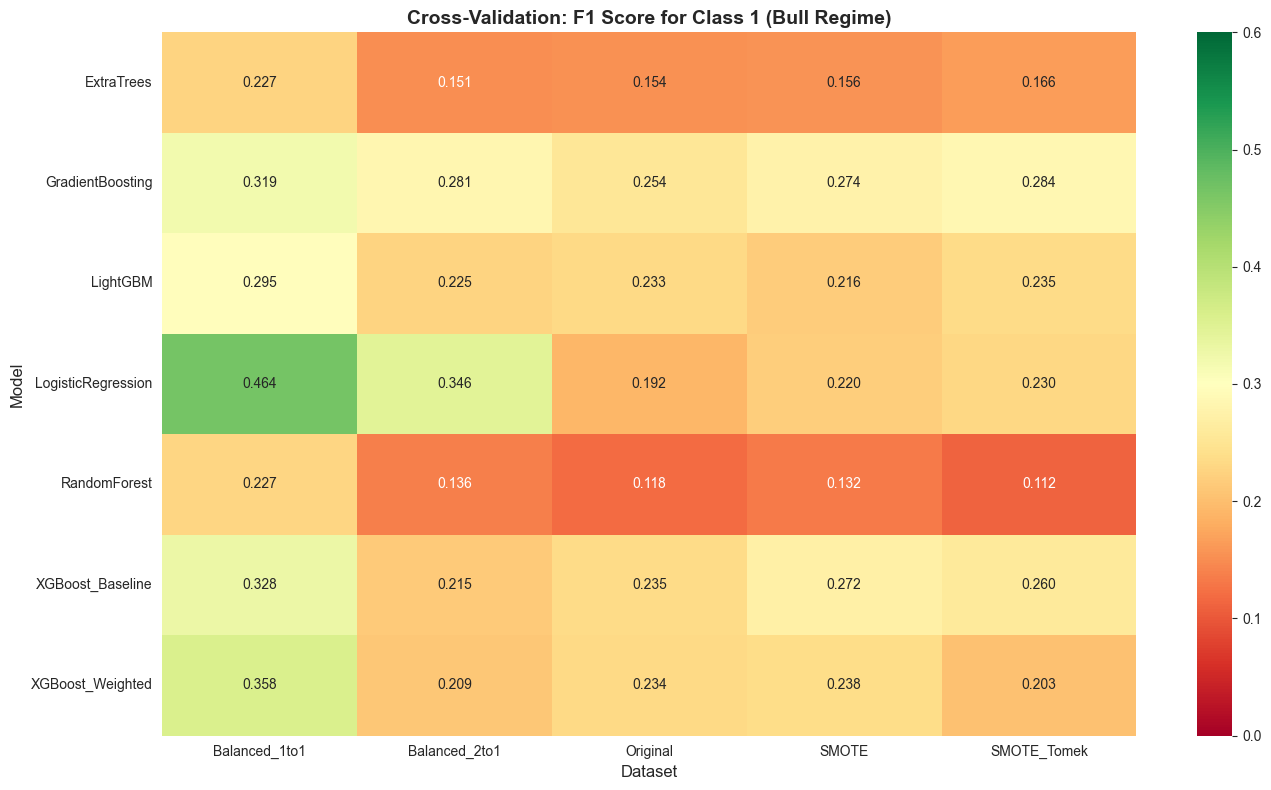

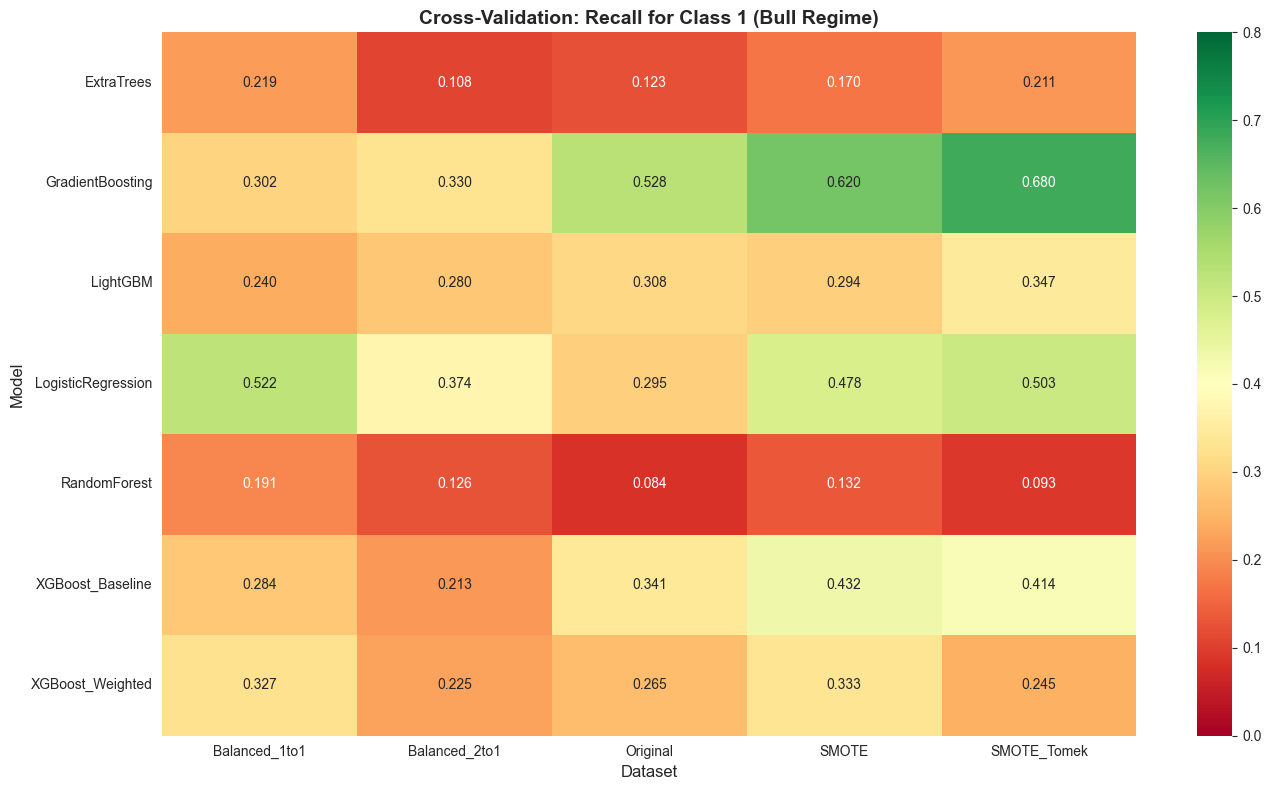

In [7]:
# Create performance heatmap for CV results
pivot_f1 = cv_summary_df.pivot(index='Model', columns='Dataset', values='F1_1')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_f1, annot=True, fmt='.3f', cmap='RdYlGn', center=0.3, vmin=0, vmax=0.6)
plt.title('Cross-Validation: F1 Score for Class 1 (Bull Regime)', fontsize=14, fontweight='bold')
plt.ylabel('Model', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.tight_layout()
plt.savefig(project_root / 'strategy' / 'cv_f1_score_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Recall heatmap
pivot_recall = cv_summary_df.pivot(index='Model', columns='Dataset', values='Recall_1')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_recall, annot=True, fmt='.3f', cmap='RdYlGn', center=0.4, vmin=0, vmax=0.8)
plt.title('Cross-Validation: Recall for Class 1 (Bull Regime)', fontsize=14, fontweight='bold')
plt.ylabel('Model', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.tight_layout()
plt.savefig(project_root / 'strategy' / 'cv_recall_score_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

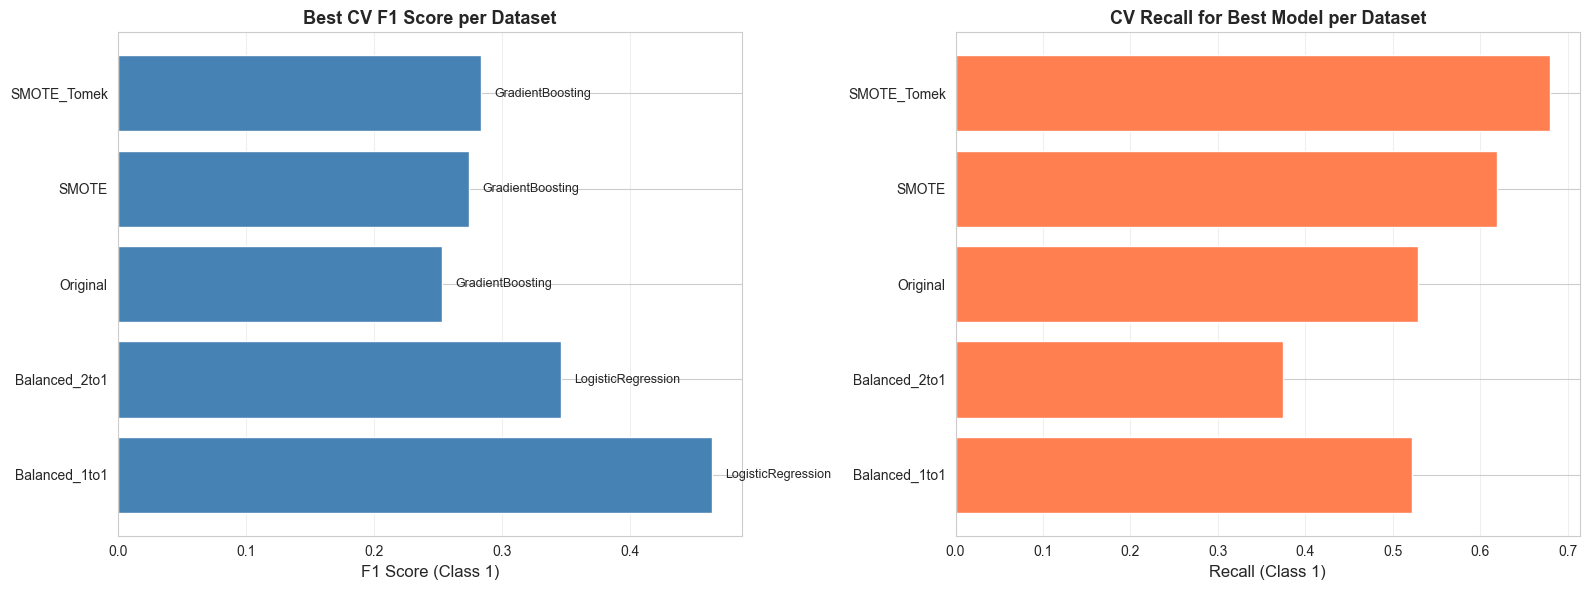

In [8]:
# Bar plot: Best model per dataset (CV results)
best_per_dataset_cv = cv_summary_df.loc[cv_summary_df.groupby('Dataset')['F1_1'].idxmax()]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1 Score
axes[0].barh(best_per_dataset_cv['Dataset'], best_per_dataset_cv['F1_1'], color='steelblue')
axes[0].set_xlabel('F1 Score (Class 1)', fontsize=12)
axes[0].set_title('Best CV F1 Score per Dataset', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add model names
for i, (idx, row) in enumerate(best_per_dataset_cv.iterrows()):
    axes[0].text(row['F1_1'] + 0.01, i, row['Model'], va='center', fontsize=9)

# Recall
axes[1].barh(best_per_dataset_cv['Dataset'], best_per_dataset_cv['Recall_1'], color='coral')
axes[1].set_xlabel('Recall (Class 1)', fontsize=12)
axes[1].set_title('CV Recall for Best Model per Dataset', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'strategy' / 'cv_best_models_per_dataset.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. CV Confusion Matrix Visualization

Show confusion matrices for top 6 model-dataset combinations from CV:

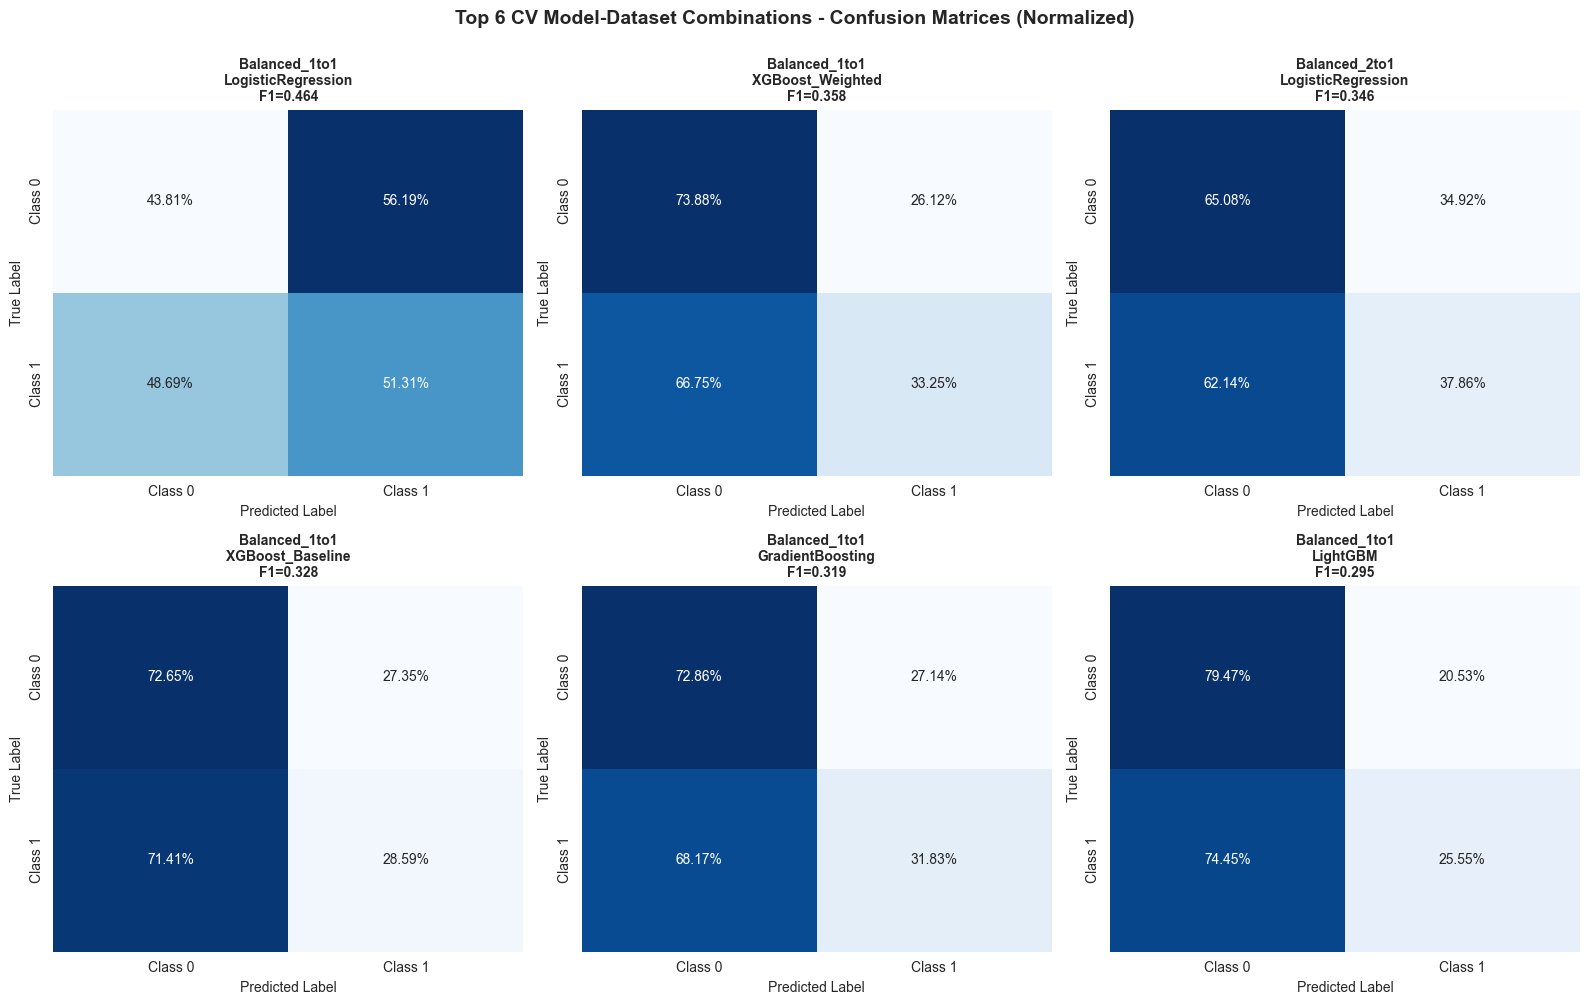

In [9]:
# Get top 6 combinations from CV
top_6_cv = cv_summary_df.head(6)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (_, row) in enumerate(top_6_cv.iterrows()):
    dataset_name = row['Dataset']
    model_name = row['Model']
    
    # Get average confusion matrix (sum across folds)
    cms = all_cv_results[dataset_name][model_name]['confusion_matrices']
    avg_cm = np.sum(cms, axis=0)
    
    # Normalize to percentages
    cm_norm = avg_cm.astype('float') / avg_cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'],
                ax=axes[idx], cbar=False)
    
    axes[idx].set_title(f"{dataset_name}\n{model_name}\nF1={row['F1_1']:.3f}", 
                        fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.suptitle('Top 6 CV Model-Dataset Combinations - Confusion Matrices (Normalized)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(project_root / 'strategy' / 'cv_top6_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Hold-Out Test Evaluation (Final Testing on Untouched 20%)

Train best models on full 80% training set and test on hold-out 20%:

In [10]:
# Select top 5 model-dataset combinations from CV for hold-out testing
top_5_combos = cv_summary_df.head(5)

holdout_results = []

print("\n" + "="*80)
print("HOLD-OUT TEST EVALUATION (Last 20% - UNTOUCHED DATA)")
print("="*80 + "\n")

for idx, (_, row) in enumerate(top_5_combos.iterrows()):
    dataset_name = row['Dataset']
    model_name = row['Model']
    
    print(f"{idx+1}. {dataset_name} + {model_name}")
    
    # Get train and test sets
    df_train = datasets_train[dataset_name]
    df_test = datasets_test[dataset_name]
    
    X_train = df_train.drop(columns=['Target'])
    y_train = df_train['Target']
    X_test = df_test.drop(columns=['Target'])
    y_test = df_test['Target']
    
    # Get model
    neg, pos = np.bincount(y_train)
    scale_pos_weight = neg / pos
    models = get_models(scale_pos_weight=scale_pos_weight)
    model = models[model_name]
    
    # Train on FULL 80% training set
    model.fit(X_train, y_train)
    
    # Predict on hold-out test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Metrics
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    
    holdout_result = {
        'dataset': dataset_name,
        'model': model_name,
        'cv_f1_1': row['F1_1'],  # CV score for comparison
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_0': report['0']['f1-score'],
        'f1_1': report['1']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'support_0': (y_test == 0).sum(),
        'support_1': (y_test == 1).sum(),
        'confusion_matrix': cm,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob
    }
    
    if y_prob is not None:
        try:
            holdout_result['roc_auc'] = roc_auc_score(y_test, y_prob)
        except:
            holdout_result['roc_auc'] = np.nan
    
    holdout_results.append(holdout_result)
    
    print(f"   Test samples: {len(y_test)} (Class 0: {holdout_result['support_0']}, Class 1: {holdout_result['support_1']})")
    print(f"   CV F1_1: {holdout_result['cv_f1_1']:.4f} | Test F1_1: {holdout_result['f1_1']:.4f}")
    print(f"   Test Recall_1: {holdout_result['recall_1']:.4f} | Test Precision_1: {holdout_result['precision_1']:.4f}")
    print(f"   Test Accuracy: {holdout_result['accuracy']:.4f}")
    
    # Signal distribution
    pred_0 = (y_pred == 0).sum()
    pred_1 = (y_pred == 1).sum()
    actual_0 = holdout_result['support_0']
    actual_1 = holdout_result['support_1']
    print(f"   Actual signals: 0={actual_0} ({actual_0/len(y_test)*100:.1f}%), 1={actual_1} ({actual_1/len(y_test)*100:.1f}%)")
    print(f"   Predicted signals: 0={pred_0} ({pred_0/len(y_pred)*100:.1f}%), 1={pred_1} ({pred_1/len(y_pred)*100:.1f}%)")
    print()

print("="*80)


HOLD-OUT TEST EVALUATION (Last 20% - UNTOUCHED DATA)

1. Balanced_1to1 + LogisticRegression
   Test samples: 104191 (Class 0: 63484, Class 1: 40707)
   CV F1_1: 0.4644 | Test F1_1: 0.0005
   Test Recall_1: 0.0003 | Test Precision_1: 0.1310
   Test Accuracy: 0.6087
   Actual signals: 0=63484 (60.9%), 1=40707 (39.1%)
   Predicted signals: 0=104107 (99.9%), 1=84 (0.1%)

2. Balanced_1to1 + XGBoost_Weighted
   Test samples: 104191 (Class 0: 63484, Class 1: 40707)
   CV F1_1: 0.3575 | Test F1_1: 0.0272
   Test Recall_1: 0.0139 | Test Precision_1: 0.6008
   Test Accuracy: 0.6111
   Actual signals: 0=63484 (60.9%), 1=40707 (39.1%)
   Predicted signals: 0=103249 (99.1%), 1=942 (0.9%)

3. Balanced_2to1 + LogisticRegression
   Test samples: 156287 (Class 0: 117819, Class 1: 38468)
   CV F1_1: 0.3461 | Test F1_1: 0.0006
   Test Recall_1: 0.0003 | Test Precision_1: 0.0579
   Test Accuracy: 0.7528
   Actual signals: 0=117819 (75.4%), 1=38468 (24.6%)
   Predicted signals: 0=156097 (99.9%), 1=190 (0.

## 9. Hold-Out Test Visualizations

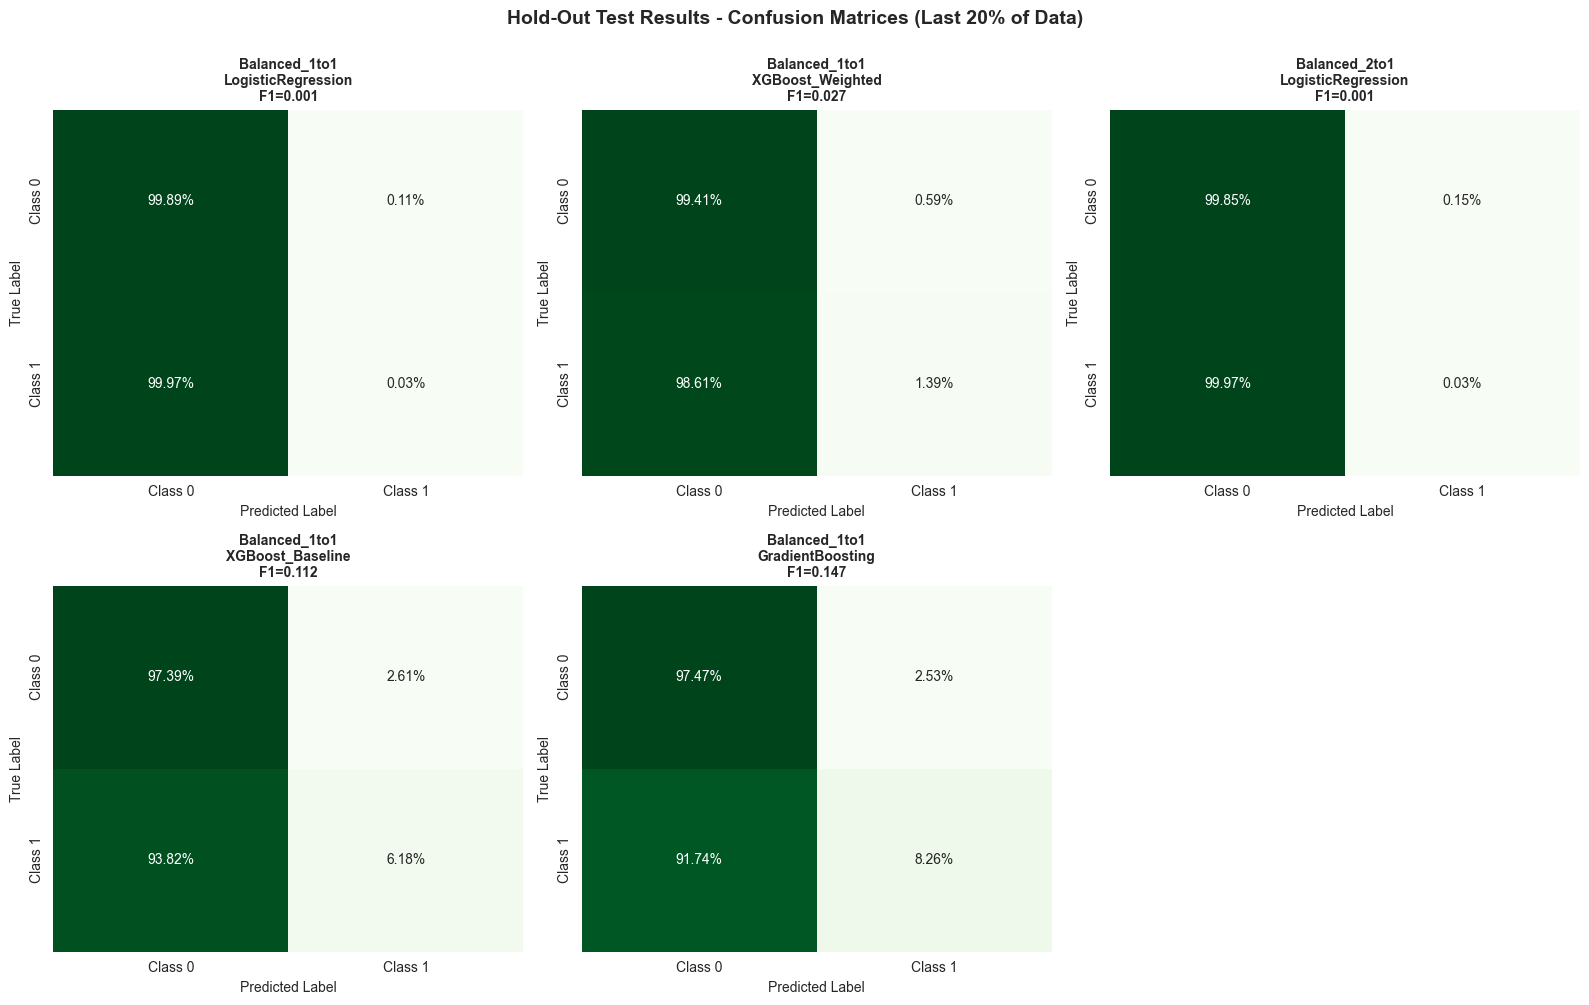

In [11]:
# Confusion matrices for hold-out test
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, result in enumerate(holdout_results):
    cm = result['confusion_matrix']
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'],
                ax=axes[idx], cbar=False)
    
    axes[idx].set_title(f"{result['dataset']}\n{result['model']}\nF1={result['f1_1']:.3f}",
                        fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

# Hide extra subplot
if len(holdout_results) < 6:
    axes[5].axis('off')

plt.suptitle('Hold-Out Test Results - Confusion Matrices (Last 20% of Data)',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(project_root / 'strategy' / 'holdout_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

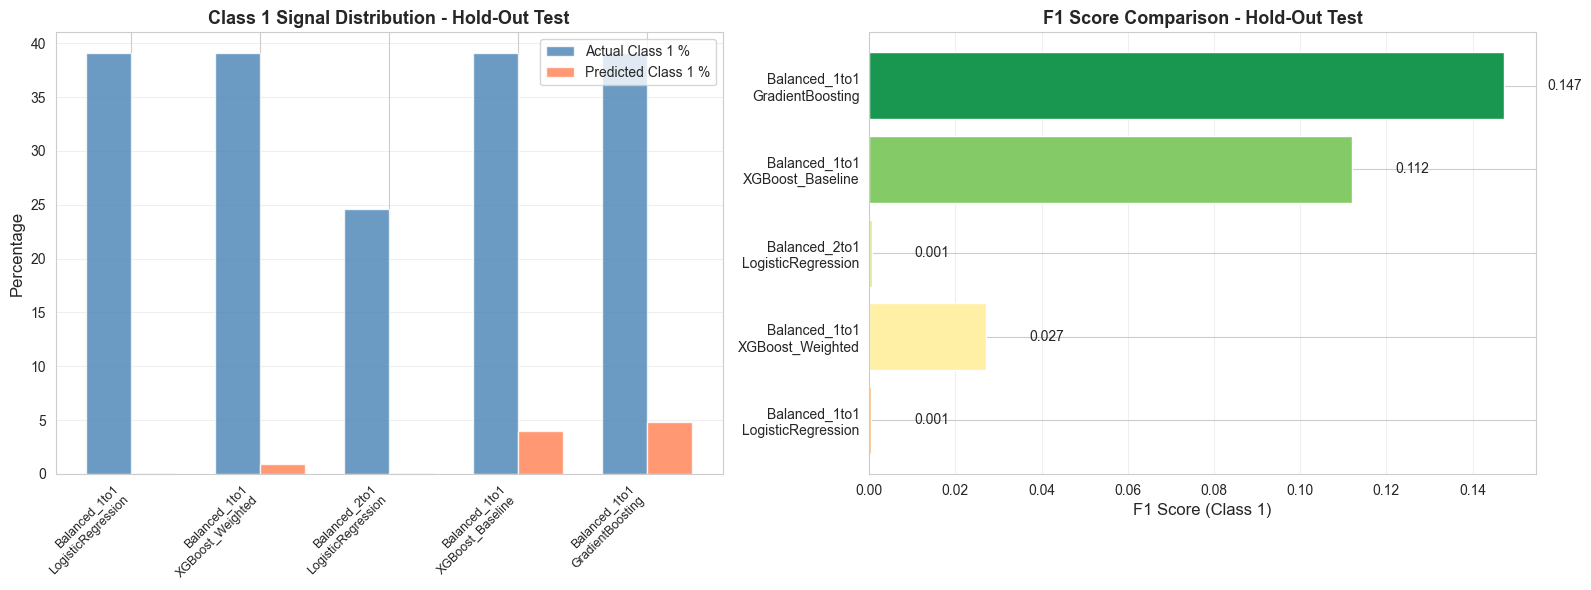

In [12]:
# Signal distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Predicted vs Actual distribution
models_labels = [f"{r['dataset']}\n{r['model']}" for r in holdout_results]
actual_class1_pct = [r['support_1'] / (r['support_0'] + r['support_1']) * 100 for r in holdout_results]
pred_class1_pct = [(r['y_pred'] == 1).sum() / len(r['y_pred']) * 100 for r in holdout_results]

x = np.arange(len(models_labels))
width = 0.35

axes[0].bar(x - width/2, actual_class1_pct, width, label='Actual Class 1 %', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, pred_class1_pct, width, label='Predicted Class 1 %', color='coral', alpha=0.8)
axes[0].set_ylabel('Percentage', fontsize=12)
axes[0].set_title('Class 1 Signal Distribution - Hold-Out Test', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_labels, rotation=45, ha='right', fontsize=9)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# F1 Score comparison
f1_scores = [r['f1_1'] for r in holdout_results]
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(f1_scores)))

axes[1].barh(models_labels, f1_scores, color=colors)
axes[1].set_xlabel('F1 Score (Class 1)', fontsize=12)
axes[1].set_title('F1 Score Comparison - Hold-Out Test', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Add values on bars
for i, v in enumerate(f1_scores):
    axes[1].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(project_root / 'strategy' / 'holdout_signal_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Final Summary and Recommendations

In [14]:
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

print("\n1. CROSS-VALIDATION RESULTS (Top 5):")
print("-" * 80)
top_5_cv_display = cv_summary_df.head(5)[['Dataset', 'Model', 'F1_1', 'Recall_1', 'Precision_1', 'Accuracy']]
print(top_5_cv_display.to_string(index=False))

print("\n\n2. HOLD-OUT TEST RESULTS (Last 20%):")
print("-" * 80)
holdout_summary = pd.DataFrame([{
    'Dataset': r['dataset'],
    'Model': r['model'],
    'CV_F1_1': r['cv_f1_1'],
    'Test_F1_1': r['f1_1'],
    'Test_Recall_1': r['recall_1'],
    'Test_Precision_1': r['precision_1'],
    'Test_Accuracy': r['accuracy'],
    'Pred_Class1_%': (r['y_pred'] == 1).sum() / len(r['y_pred']) * 100
} for r in holdout_results])
print(holdout_summary.to_string(index=False))

# Save holdout results
holdout_summary.to_csv(project_root / 'strategy' / 'holdout_test_results.csv', index=False)

print("\n\n3. BEST MODEL RECOMMENDATION:")
print("-" * 80)
best_combo = cv_summary_df.iloc[0]
print(f"Dataset: {best_combo['Dataset']}")
print(f"Model: {best_combo['Model']}")
print(f"CV F1 (Class 1): {best_combo['F1_1']:.4f}")
print(f"CV Recall (Class 1): {best_combo['Recall_1']:.4f}")
print(f"CV Precision (Class 1): {best_combo['Precision_1']:.4f}")

print("\n\n4. KEY INSIGHTS:")
print("-" * 80)

# Which dataset works best?
dataset_performance = cv_summary_df.groupby('Dataset')['F1_1'].mean().sort_values(ascending=False)
print(f"\nBest performing dataset (avg F1_1): {dataset_performance.index[0]} ({dataset_performance.iloc[0]:.4f})")

# Which model works best?
model_performance = cv_summary_df.groupby('Model')['F1_1'].mean().sort_values(ascending=False)
print(f"Best performing model (avg F1_1): {model_performance.index[0]} ({model_performance.iloc[0]:.4f})")

# Comparison to original baseline
if 'Original' in all_cv_results and 'XGBoost_Baseline' in all_cv_results['Original']:
    baseline_f1 = all_cv_results['Original']['XGBoost_Baseline']['avg_metrics']['f1_1']
    best_f1 = best_combo['F1_1']
    improvement = (best_f1 - baseline_f1) / baseline_f1 * 100
    print(f"\nImprovement over baseline: {improvement:+.1f}% (from {baseline_f1:.4f} to {best_f1:.4f})")

# CV vs Test performance comparison
print("\n\n5. CV vs HOLD-OUT TEST PERFORMANCE:")
print("-" * 80)
for r in holdout_results:
    diff = r['f1_1'] - r['cv_f1_1']
    diff_pct = (diff / r['cv_f1_1']) * 100 if r['cv_f1_1'] > 0 else 0
    print(f"{r['dataset']:15s} + {r['model']:20s}: CV={r['cv_f1_1']:.4f}, Test={r['f1_1']:.4f}, Diff={diff:+.4f} ({diff_pct:+.1f}%)")

print("\n" + "="*80)


FINAL SUMMARY

1. CROSS-VALIDATION RESULTS (Top 5):
--------------------------------------------------------------------------------
      Dataset              Model     F1_1  Recall_1  Precision_1  Accuracy
Balanced_1to1 LogisticRegression 0.464425  0.522263     0.495657  0.476050
Balanced_1to1   XGBoost_Weighted 0.357535  0.327175     0.622134  0.533136
Balanced_2to1 LogisticRegression 0.346137  0.374311     0.359829  0.559530
Balanced_1to1   XGBoost_Baseline 0.328406  0.284370     0.540745  0.503421
Balanced_1to1   GradientBoosting 0.318794  0.301648     0.610869  0.520881


2. HOLD-OUT TEST RESULTS (Last 20%):
--------------------------------------------------------------------------------
      Dataset              Model  CV_F1_1  Test_F1_1  Test_Recall_1  Test_Precision_1  Test_Accuracy  Pred_Class1_%
Balanced_1to1 LogisticRegression 0.464425   0.000539       0.000270          0.130952       0.608709       0.080621
Balanced_1to1   XGBoost_Weighted 0.357535   0.027180       0.013

## 11. Original Dataset - All Models Hold-Out Test Evaluation

Evaluate ALL models trained on the Original (imbalanced) dataset on the untouched 20% test set:

In [15]:
# Comprehensive evaluation of ALL models on Original dataset test set
original_holdout_results = []

print("\n" + "="*80)
print("ORIGINAL DATASET - ALL MODELS HOLD-OUT TEST (Last 20%)")
print("="*80 + "\n")

if 'Original' in datasets_train and 'Original' in datasets_test:
    # Get Original dataset train/test
    df_train = datasets_train['Original']
    df_test = datasets_test['Original']
    
    X_train = df_train.drop(columns=['Target'])
    y_train = df_train['Target']
    X_test = df_test.drop(columns=['Target'])
    y_test = df_test['Target']
    
    # Calculate scale_pos_weight
    neg, pos = np.bincount(y_train)
    scale_pos_weight = neg / pos
    
    print(f"Original Dataset Test Set:")
    print(f"  Samples: {len(y_test)}")
    print(f"  Class 0: {(y_test==0).sum()} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
    print(f"  Class 1: {(y_test==1).sum()} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")
    print(f"  Scale pos weight: {scale_pos_weight:.2f}\n")
    
    # Get all models
    models = get_models(scale_pos_weight=scale_pos_weight)
    
    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        
        try:
            # Train on full 80% training set
            model.fit(X_train, y_train)
            
            # Predict on hold-out 20% test set
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
            
            # Metrics
            report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
            cm = confusion_matrix(y_test, y_pred)
            
            result = {
                'model': model_name,
                'accuracy': accuracy_score(y_test, y_pred),
                'f1_0': report['0']['f1-score'],
                'f1_1': report['1']['f1-score'],
                'precision_0': report['0']['precision'],
                'precision_1': report['1']['precision'],
                'recall_0': report['0']['recall'],
                'recall_1': report['1']['recall'],
                'support_0': (y_test == 0).sum(),
                'support_1': (y_test == 1).sum(),
                'confusion_matrix': cm,
                'y_pred': y_pred,
                'y_prob': y_prob
            }
            
            if y_prob is not None:
                try:
                    result['roc_auc'] = roc_auc_score(y_test, y_prob)
                except:
                    result['roc_auc'] = np.nan
            
            original_holdout_results.append(result)
            
            # Print metrics
            pred_1_count = (y_pred == 1).sum()
            print(f"  F1_1: {result['f1_1']:.4f} | Recall_1: {result['recall_1']:.4f} | Precision_1: {result['precision_1']:.4f}")
            print(f"  Accuracy: {result['accuracy']:.4f} | Predicted Class 1: {pred_1_count} ({pred_1_count/len(y_pred)*100:.1f}%)\n")
            
        except Exception as e:
            print(f"  ERROR: {e}\n")
            continue
    
    print("="*80)
else:
    print("Original dataset not found!")


ORIGINAL DATASET - ALL MODELS HOLD-OUT TEST (Last 20%)

Original Dataset Test Set:
  Samples: 263770
  Class 0: 227887 (86.4%)
  Class 1: 35883 (13.6%)
  Scale pos weight: 3.70

Evaluating LogisticRegression...
  F1_1: 0.0931 | Recall_1: 0.1503 | Precision_1: 0.0675
  Accuracy: 0.6019 | Predicted Class 1: 79921 (30.3%)

Evaluating RandomForest...
  F1_1: 0.0231 | Recall_1: 0.0123 | Precision_1: 0.1849
  Accuracy: 0.8582 | Predicted Class 1: 2391 (0.9%)

Evaluating ExtraTrees...
  F1_1: 0.0222 | Recall_1: 0.0112 | Precision_1: 1.0000
  Accuracy: 0.8655 | Predicted Class 1: 403 (0.2%)

Evaluating GradientBoosting...
  F1_1: 0.1180 | Recall_1: 0.2237 | Precision_1: 0.0801
  Accuracy: 0.5449 | Predicted Class 1: 100212 (38.0%)

Evaluating XGBoost_Baseline...
  F1_1: 0.2228 | Recall_1: 0.3304 | Precision_1: 0.1681
  Accuracy: 0.6865 | Predicted Class 1: 70530 (26.7%)

Evaluating XGBoost_Weighted...
  F1_1: 0.1292 | Recall_1: 0.1009 | Precision_1: 0.1793
  Accuracy: 0.8148 | Predicted Class

## Original Dataset - Results Summary Table

In [16]:
# Create summary table for Original dataset results
original_summary_df = pd.DataFrame(original_holdout_results)

# Sort by F1_1 score
original_summary_df = original_summary_df.sort_values('f1_1', ascending=False)

print("\n" + "="*80)
print("ORIGINAL DATASET - HOLD-OUT TEST RESULTS (All Models)")
print("="*80)
print("\nRanked by F1 Score (Class 1):\n")

display_cols = ['model', 'f1_1', 'recall_1', 'precision_1', 'f1_0', 'accuracy']
if 'roc_auc' in original_summary_df.columns:
    display_cols.append('roc_auc')

print(original_summary_df[display_cols].to_string(index=False))

# Save to CSV
output_path = project_root / 'strategy' / 'original_dataset_holdout_results.csv'
original_summary_df[display_cols].to_csv(output_path, index=False)
print(f"\nResults saved to: {output_path}")
print("="*80)


ORIGINAL DATASET - HOLD-OUT TEST RESULTS (All Models)

Ranked by F1 Score (Class 1):

             model     f1_1  recall_1  precision_1     f1_0  accuracy  roc_auc
  XGBoost_Baseline 0.222830  0.330407     0.168099 0.803620  0.686465 0.520374
  XGBoost_Weighted 0.129166  0.100939     0.179307 0.896408  0.814842 0.535570
  GradientBoosting 0.117976  0.223727     0.080110 0.693344  0.544910 0.431266
LogisticRegression 0.093140  0.150294     0.067479 0.744939  0.601858 0.396157
          LightGBM 0.056633  0.031854     0.255020 0.921837  0.855636 0.505551
      RandomForest 0.023097  0.012318     0.184860 0.923579  0.858248 0.467589
        ExtraTrees 0.022212  0.011231     1.000000 0.927777  0.865489 0.524993

Results saved to: E:\Coding\Crypto_Research\strategy\original_dataset_holdout_results.csv


## Original Dataset - Confusion Matrix Visualization

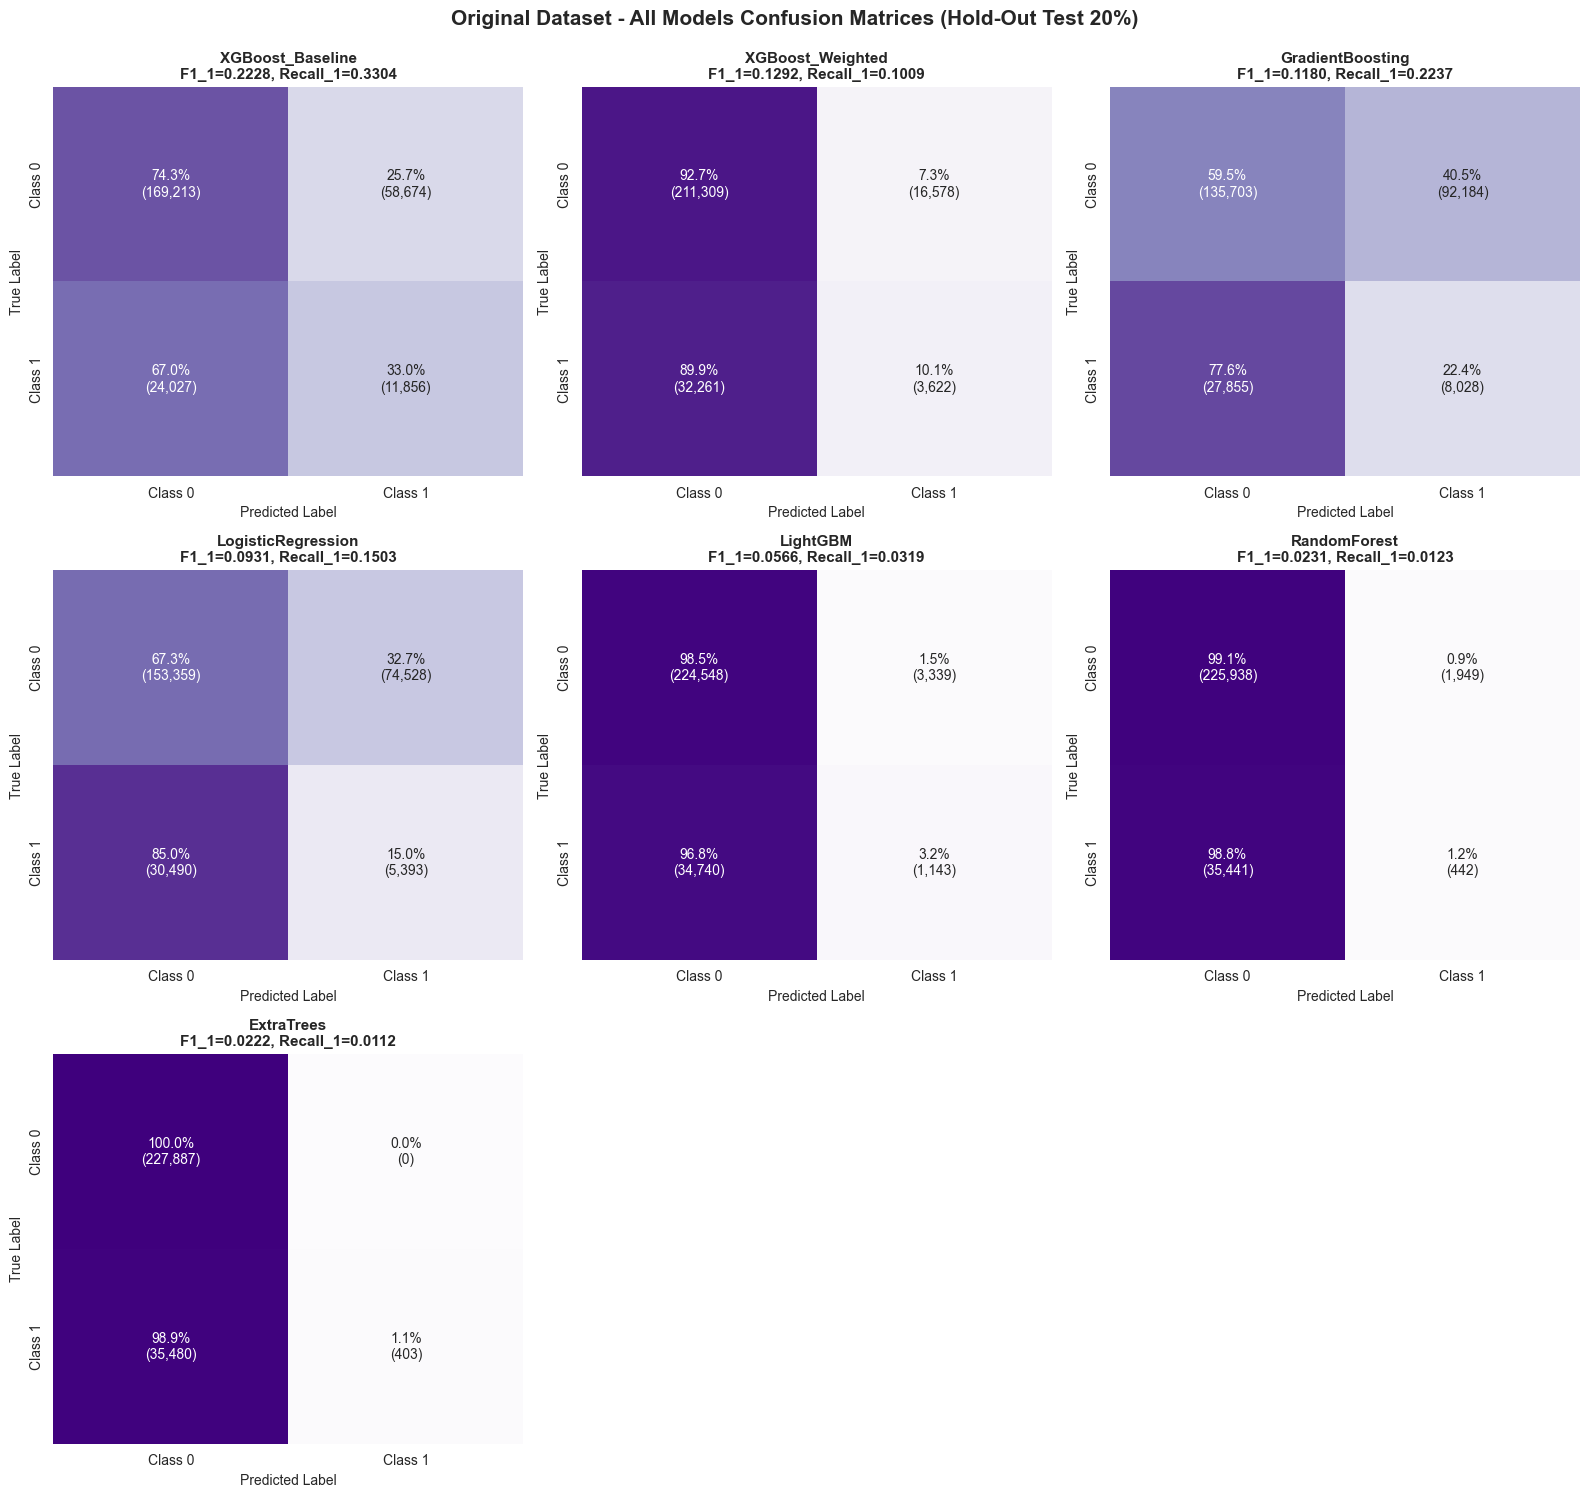

In [17]:
# Plot confusion matrices for all Original dataset models
n_models = len(original_holdout_results)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, result in enumerate(original_summary_df.itertuples()):
    # Get the actual result dict (not from dataframe)
    result_dict = original_holdout_results[original_summary_df.index[idx]]
    cm = result_dict['confusion_matrix']
    
    # Normalize to percentages
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Purples',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'],
                ax=axes[idx], cbar=False, vmin=0, vmax=1)
    
    # Add count annotations
    for i in range(2):
        for j in range(2):
            text = axes[idx].texts[i*2 + j]
            count = cm[i, j]
            text.set_text(f'{cm_norm[i,j]:.1%}\n({count:,})')
    
    axes[idx].set_title(f"{result.model}\nF1_1={result.f1_1:.4f}, Recall_1={result.recall_1:.4f}",
                        fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

# Hide unused subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Original Dataset - All Models Confusion Matrices (Hold-Out Test 20%)',
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(project_root / 'strategy' / 'original_dataset_all_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## Original Dataset - Performance Metrics Visualization

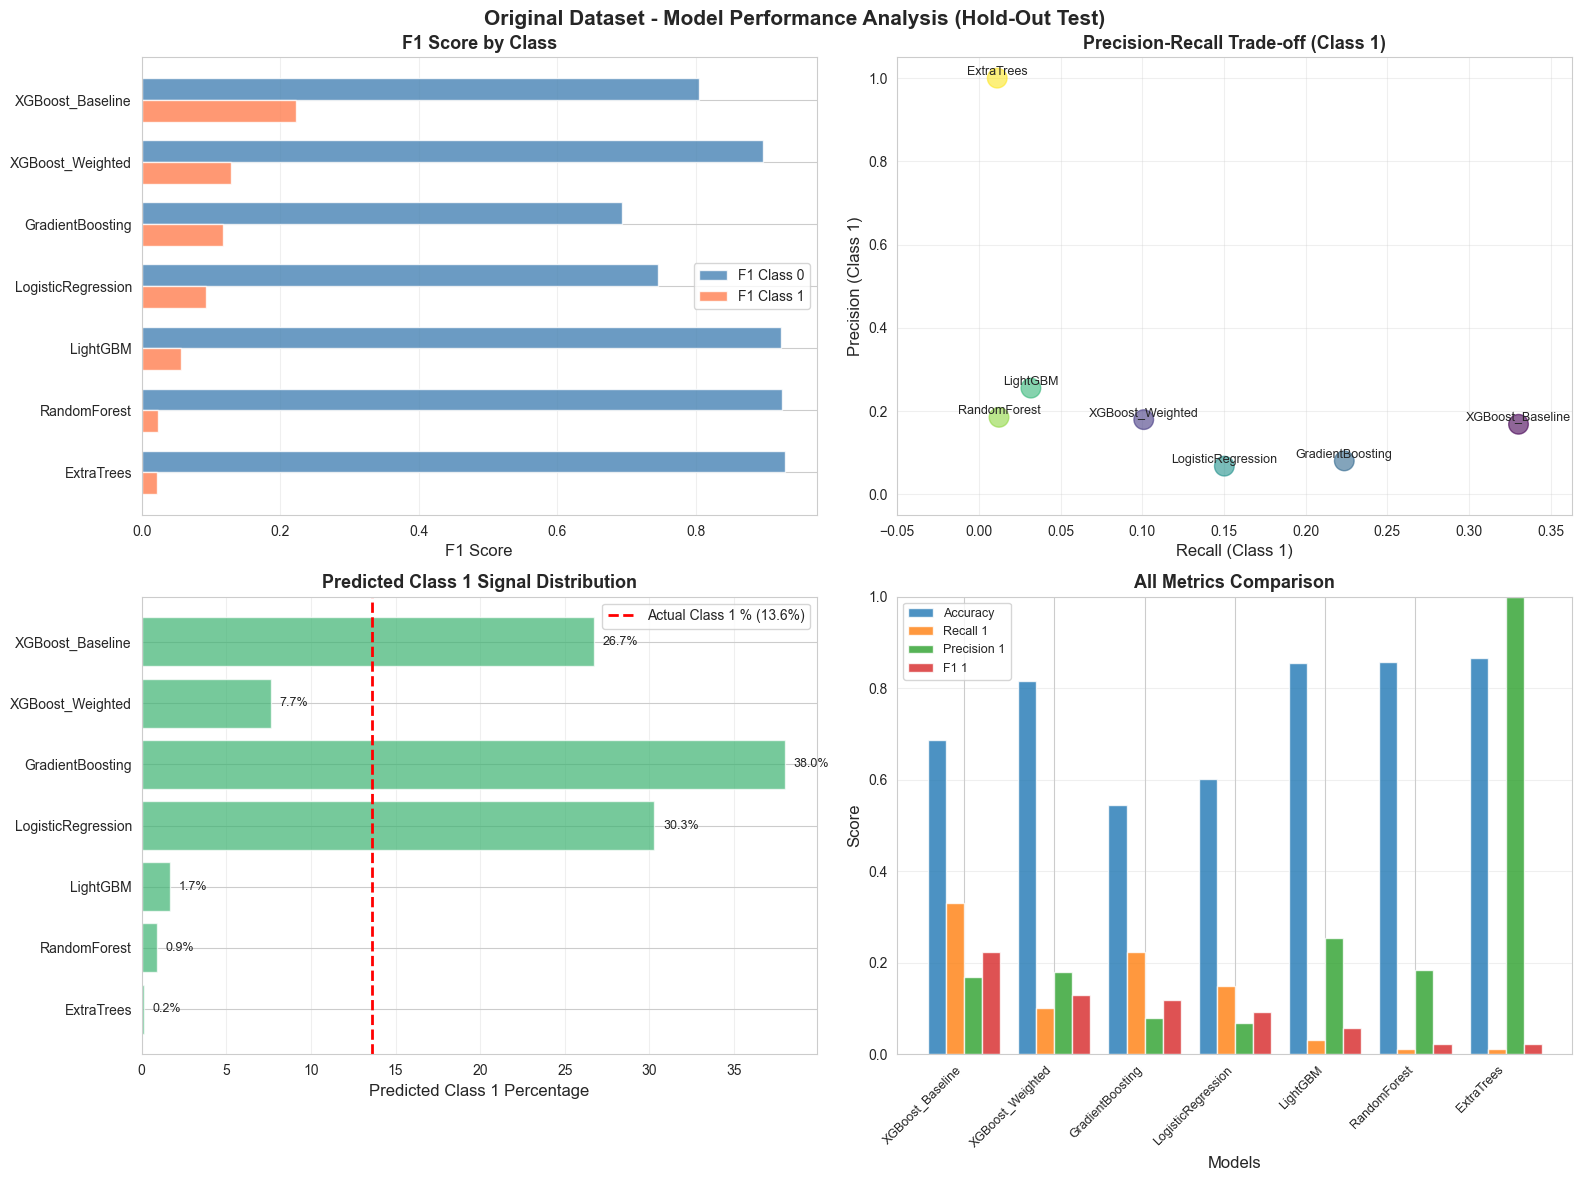

In [18]:
# Performance comparison visualization for Original dataset
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. F1 Score comparison (both classes)
ax = axes[0, 0]
x = np.arange(len(original_summary_df))
width = 0.35

ax.barh(x - width/2, original_summary_df['f1_0'], width, label='F1 Class 0', color='steelblue', alpha=0.8)
ax.barh(x + width/2, original_summary_df['f1_1'], width, label='F1 Class 1', color='coral', alpha=0.8)
ax.set_yticks(x)
ax.set_yticklabels(original_summary_df['model'])
ax.set_xlabel('F1 Score', fontsize=12)
ax.set_title('F1 Score by Class', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

# 2. Precision vs Recall (Class 1)
ax = axes[0, 1]
ax.scatter(original_summary_df['recall_1'], original_summary_df['precision_1'], 
           s=200, alpha=0.6, c=range(len(original_summary_df)), cmap='viridis')

for idx, row in original_summary_df.iterrows():
    ax.annotate(row['model'], 
                (row['recall_1'], row['precision_1']),
                fontsize=9, ha='center', va='bottom')

ax.set_xlabel('Recall (Class 1)', fontsize=12)
ax.set_ylabel('Precision (Class 1)', fontsize=12)
ax.set_title('Precision-Recall Trade-off (Class 1)', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xlim(-0.05, max(original_summary_df['recall_1']) * 1.1)
ax.set_ylim(-0.05, 1.05)

# 3. Signal distribution (Predicted Class 1 %)
ax = axes[1, 0]
pred_class1_pcts = [(r['y_pred'] == 1).sum() / len(r['y_pred']) * 100 
                    for r in original_holdout_results]

# Reorder to match sorted dataframe
pred_class1_pcts_sorted = [pred_class1_pcts[i] for i in original_summary_df.index]

ax.barh(range(len(original_summary_df)), pred_class1_pcts_sorted, color='mediumseagreen', alpha=0.7)
ax.axvline(x=13.6, color='red', linestyle='--', linewidth=2, label='Actual Class 1 % (13.6%)')
ax.set_yticks(range(len(original_summary_df)))
ax.set_yticklabels(original_summary_df['model'])
ax.set_xlabel('Predicted Class 1 Percentage', fontsize=12)
ax.set_title('Predicted Class 1 Signal Distribution', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

# Add values on bars
for i, v in enumerate(pred_class1_pcts_sorted):
    ax.text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9)

# 4. Overall metrics comparison
ax = axes[1, 1]
metrics_to_plot = ['accuracy', 'recall_1', 'precision_1', 'f1_1']
x_pos = np.arange(len(original_summary_df))
bar_width = 0.2

for i, metric in enumerate(metrics_to_plot):
    offset = (i - len(metrics_to_plot)/2 + 0.5) * bar_width
    ax.bar(x_pos + offset, original_summary_df[metric], bar_width, 
           label=metric.replace('_', ' ').title(), alpha=0.8)

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('All Metrics Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(original_summary_df['model'], rotation=45, ha='right', fontsize=9)
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

plt.suptitle('Original Dataset - Model Performance Analysis (Hold-Out Test)',
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(project_root / 'strategy' / 'original_dataset_performance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary - File Outputs

In [ ]:
print("\n" + "="*80)
print("ALL FILES CREATED")
print("="*80)
print("\nCSV Files:")
print("  1. cv_results_comparison.csv - All cross-validation results")
print("  2. holdout_test_results.csv - Top 5 models hold-out test results")
print("  3. original_dataset_holdout_results.csv - All models on Original dataset")

print("\nVisualization Files:")
print("  1. cv_f1_score_heatmap.png - CV F1 scores heatmap")
print("  2. cv_recall_score_heatmap.png - CV Recall scores heatmap")
print("  3. cv_best_models_per_dataset.png - Best model per dataset")
print("  4. cv_top6_confusion_matrices.png - Top 6 CV confusion matrices")
print("  5. holdout_confusion_matrices.png - Top 5 hold-out confusion matrices")
print("  6. holdout_signal_distribution.png - Top 5 signal distribution")
print("  7. original_dataset_all_confusion_matrices.png - All models on Original dataset")
print("  8. original_dataset_performance_analysis.png - Original dataset performance metrics")

print("\n" + "="*80)
print("NOTEBOOK EXECUTION COMPLETE")
print("="*80)